# VGG16 RAVDESS Walkthrough using explainer
Pulled from Muriel Kosaka's following articles:\
https://towardsdatascience.com/speech-emotion-recognition-using-ravdess-audio-dataset-ce19d162690\
https://towardsdatascience.com/fine-tuning-pre-trained-model-vgg-16-1277268c537f

## Table of Contents
#### 1. Data exploration 
#### 2. Dataset generation
#### 2. Load the trained VGG16
#### 3. Implement the metrics explainer plugin
#### 4. Implmenet the deep explainer
#### 5. Implement the gradient explainer

In [47]:
# IMPORT NECESSARY LIBRARIES
import warnings
warnings.filterwarnings('ignore')
import PIL
#import librosa
%matplotlib inline
import matplotlib.pyplot as plt
#import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


# if on Intel AI kit env run:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
# in not on Intel AI kit env run:
#from keras.optimizers import SGD
#from keras.utils import to_categorical


from keras.regularizers import l2
#import seaborn as sns
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import classification_report

Text(0.5, 1, 'Waveplot - Male Happy')

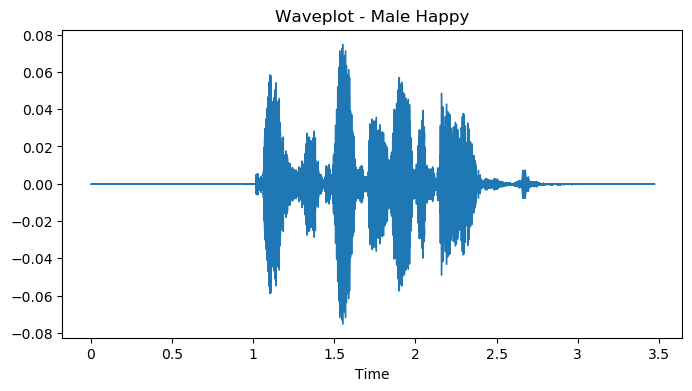

In [28]:
# set the path to where your dataset is
dataset_path = '../../../../data'
train_dir = '../../../../train_logmel'


# LOAD IN FILE
import librosa
from librosa.display import waveshow
happy, sr = librosa.load(os.path.join(dataset_path,'03-01-03-01-01-02-01.wav'))
sad, sr = librosa.load(os.path.join(dataset_path,'03-01-04-01-01-02-01.wav'))
# PLAY AUDIO FILE
#librosa.write_wav('ipd.Audio Files/MaleNeutral.wav', x, sr)
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
waveshow(happy, sr=sr)
plt.title('Waveplot - Male Happy')

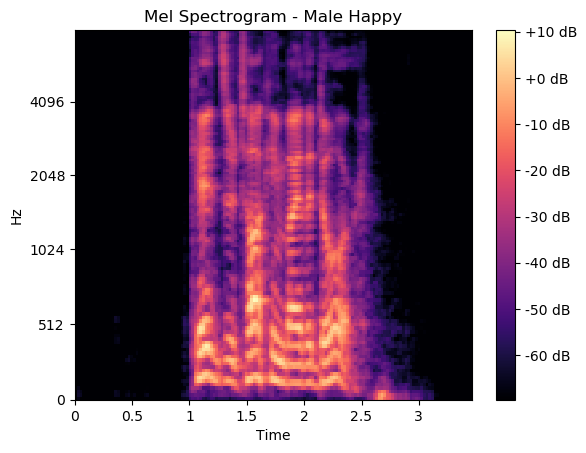

In [31]:
# CREATE LOG MEL SPECTROGRAM
spectrogram = librosa.feature.melspectrogram(y=happy, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Happy')
plt.colorbar(format='%+2.0f dB');

In [29]:
Audio(data=happy, rate=sr)

Text(0.5, 1, 'Waveplot - Male Sad')

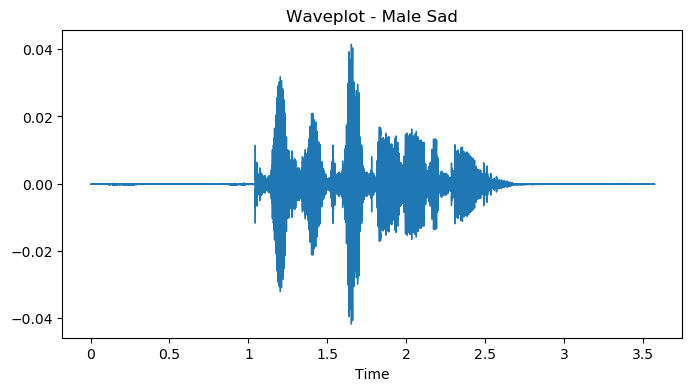

In [37]:
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
waveshow(sad, sr=sr)
plt.title('Waveplot - Male Sad')

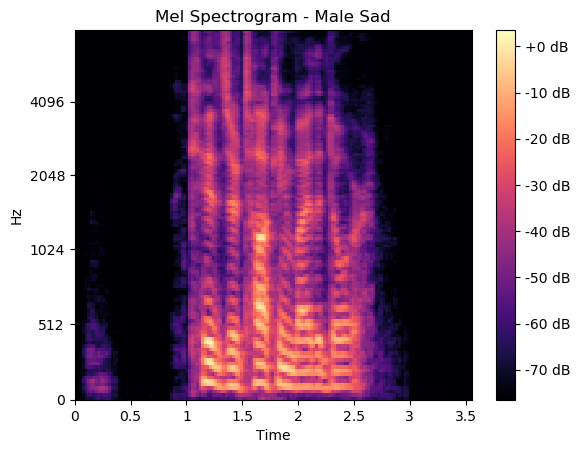

In [34]:
# CREATE LOG MEL SPECTROGRAM
spectrogram = librosa.feature.melspectrogram(y=sad, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Sad')
plt.colorbar(format='%+2.0f dB');

In [35]:
Audio(data=sad, rate=sr)

In [38]:
# Collect samples for training/validation

import glob
angry = glob.glob(os.path.join(train_dir,'angry/*.*'))
calm = glob.glob(os.path.join(train_dir,'calm/*.*'))
disgust = glob.glob(os.path.join(train_dir,'disgust/*.*'))
fearful = glob.glob(os.path.join(train_dir,'fear/*.*'))
happy = glob.glob(os.path.join(train_dir,'happy/*.*'))
neutral = glob.glob(os.path.join(train_dir,'neutral/*.*'))
sad = glob.glob(os.path.join(train_dir,'sad/*.*'))
surprised = glob.glob(os.path.join(train_dir,'surprise/*.*'))

data = []
labels = []
for i in angry:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Angry')
for i in calm:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Calm')
for i in disgust:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Disgust')
for i in fearful:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Fearful')
for i in happy:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Happy')
for i in neutral:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Neutral')
for i in sad:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Sad')
for i in surprised:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append('Surprised')
    
    
# random split the 80/20 train/val examples
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(np.array(data), np.array(labels),
                                                  test_size=0.2, random_state=0)
train_labels = y_train
val_labels = y_val
# normalize
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_val /= 255

# one-hot encode classes
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_val = to_categorical(lb.fit_transform(y_val))

In [39]:
# load the model
clf = tf.keras.models.load_model('../../../../no_aug_VGG_TL.hdf5')

# Explainer plugins 

### metrics_explainer

In [40]:
y = clf.predict(X_val)

In [41]:
from explainer.explainers import metrics_explainer
cm = metrics_explainer['confusionmatrix'](y_val, y, lb.classes_)

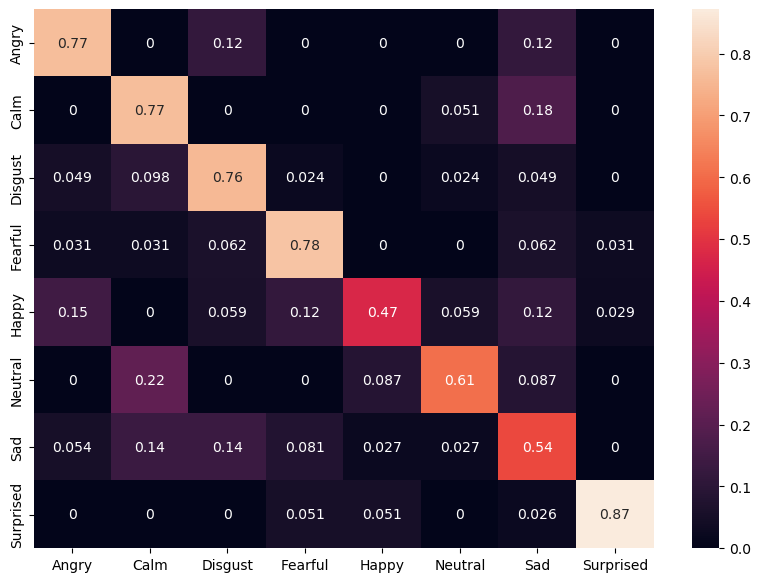

In [42]:
cm.visualize()

In [43]:
print(cm.report)

              precision    recall  f1-score   support

       Angry       0.77      0.77      0.77        43
        Calm       0.67      0.77      0.71        39
     Disgust       0.69      0.76      0.72        41
     Fearful       0.71      0.78      0.75        32
       Happy       0.76      0.47      0.58        34
     Neutral       0.70      0.61      0.65        23
         Sad       0.47      0.54      0.50        37
   Surprised       0.94      0.87      0.91        39

    accuracy                           0.70       288
   macro avg       0.71      0.70      0.70       288
weighted avg       0.72      0.70      0.70       288



### GradientExplainer

In [44]:
[happy_i, sad_i] = lb.transform(['Happy', 'Sad'])
happy_indxs = []
sad_indxs = []
for i, ex in enumerate(y_val):
    if ex[happy_i] == 1:
        happy_indxs.append(i)
    elif ex[sad_i] == 1:
        sad_indxs.append(i)
background = np.delete(X_val, happy_indxs,0)
test_images = X_val[happy_indxs]

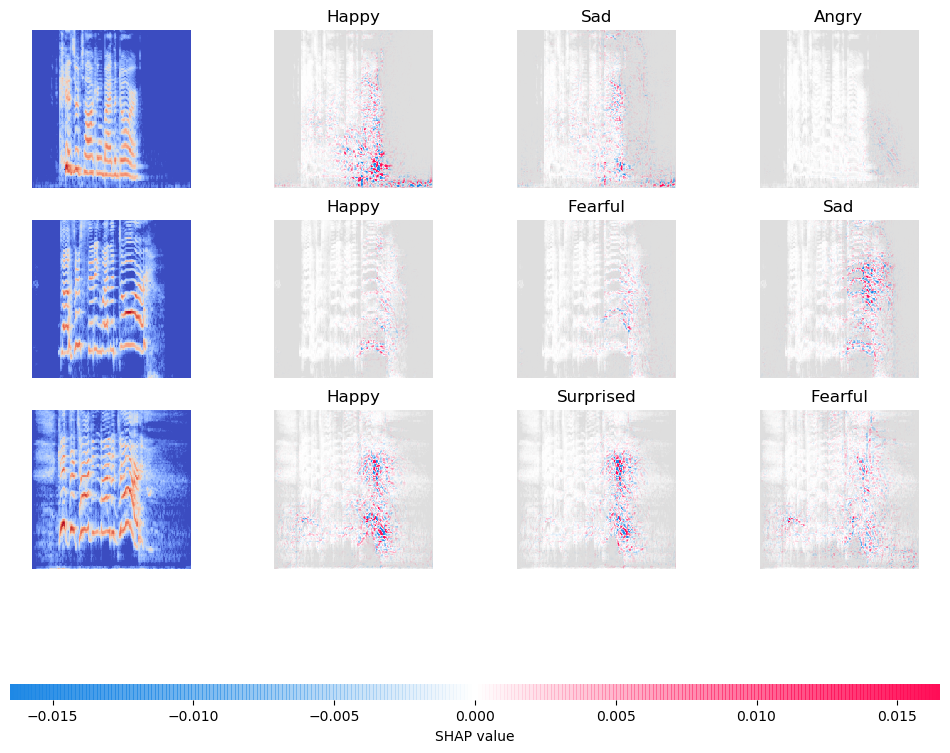

In [45]:
from explainer.explainers import feature_attributions_explainer
gradientexplainer =  feature_attributions_explainer['gradientexplainer']
gaViz = gradientexplainer(clf,background[:20],test_images[:3],3,lb)
gaViz.visualize(test_images[:3])

### DeepExplainer

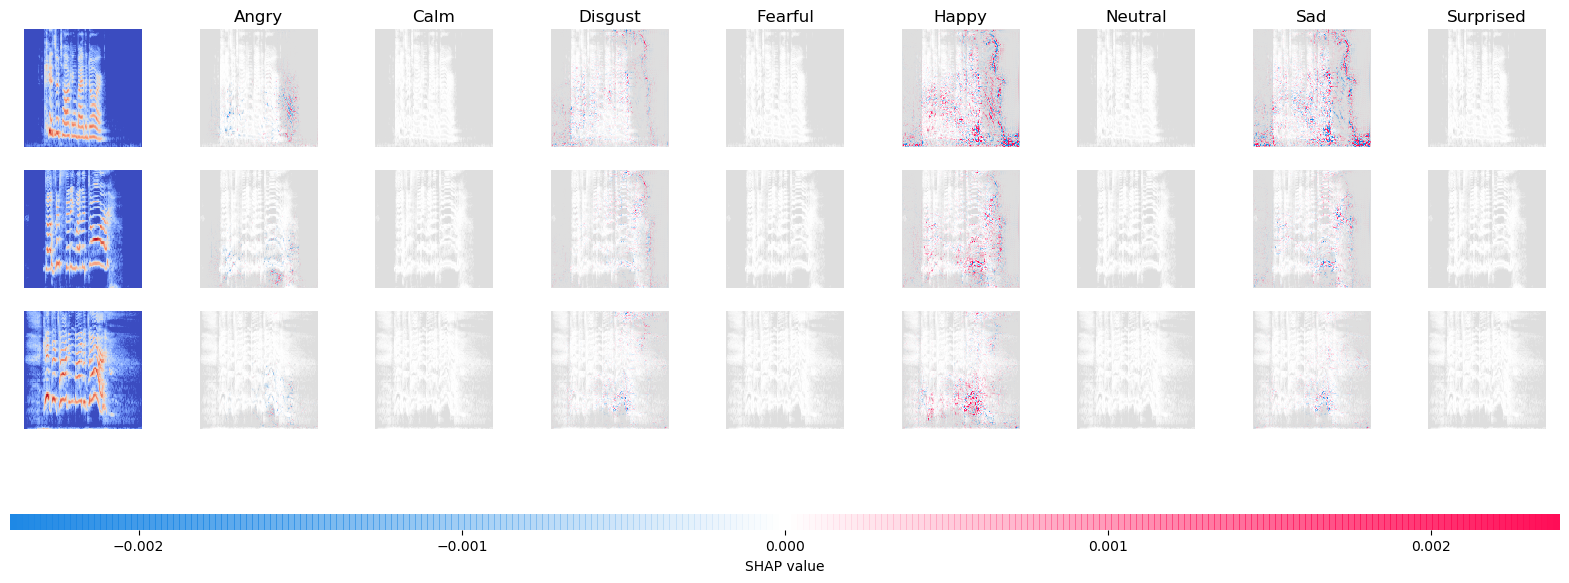

In [10]:
from explainer.explainers import feature_attributions_explainer
deepexplainer =  feature_attributions_explainer['deepexplainer']
deViz = deepexplainer(clf,background[:2],test_images[:3],lb)
deViz.visualize(test_images[:3])